### 作業目的: 透過實作加速版word2vec Skip-gram模型來更加了解高速版的word2vec

本次作業會採用Penn Tree Bank資料及，學員可以在ptb.train.txt中取得訓練文本資料。這次作業可以讓學員練習到以pytorch搭建模型與進行文本資料的前處理

PS: 建議學員使用Colab (或可以使用GPU加速的機器)來進行作業，不然訓練會訓練到天荒地老.....

### Connect to Google Drive

In [1]:
# Import libraries for importing files from Google drive to Colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authorize Google SDK to access Google Drive from Colab

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
download = drive.CreateFile({'id': '1-AN38RxLdlmsv6gHTBYdX-AKthZTHjJz'})
download.GetContentFile('ptb.train.txt')

### Import Necessary Libraries

In [3]:
import os
import re
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import urllib.request
from typing import List
from collections import Counter
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [4]:
# 讀取資料

# Penn Tree Back dataset
with open("./ptb.train.txt", encoding='utf-8') as f:
    lines = f.readlines()
    
print(f"Total {len(lines)} lines")
raw_dataset = [line.split() for line in lines]

Total 42068 lines


In [5]:
# 查看前2筆
raw_dataset[:2]

[['aer',
  'banknote',
  'berlitz',
  'calloway',
  'centrust',
  'cluett',
  'fromstein',
  'gitano',
  'guterman',
  'hydro-quebec',
  'ipo',
  'kia',
  'memotec',
  'mlx',
  'nahb',
  'punts',
  'rake',
  'regatta',
  'rubens',
  'sim',
  'snack-food',
  'ssangyong',
  'swapo',
  'wachter'],
 ['pierre',
  '<unk>',
  'N',
  'years',
  'old',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'nov.',
  'N']]

In [6]:
# 定義資料前處理函示
class PreProcessor():
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    min_freq: int
        minimum frequency of a word to be kept
    do_subsampling: bool
        whether to do subsampling
    '''
    
    def __init__(self, only_word: bool=False, min_freq: int=5, do_subsampling: bool=True, t: float=1e-5):
        self.only_word = only_word
        self.min_freq = min_freq
        self.do_subsampling = do_subsampling
        self.t = t
    
    def process(self, corpus: List[str]):
        
        word_dic = set()
        counter = Counter()
        processed_sentence = []
        
        for sentence in corpus:
            # hint: 請計算字詞頻率
            ### <your code> ###
            sentence = [word.lower() for word in sentence]
            counter.update(sentence)
            processed_sentence.append(sentence)
    
        # hint: 移除頻率過小的字詞 建立word2idx與idx2word與word_frequency辭典
        word_cnt = dict(filter(lambda x: x[1] > self.min_freq, counter.items()))
        self.word2idx = {word: idx for idx, word in enumerate(word_cnt)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.word_frequency =  word_cnt
        
        #將文本轉為ID型式與移除文本中頻率過小的文字
        self.processed_corpus = [[self.word2idx[word] for word in sentence if self.word2idx.get(word)] for sentence in processed_sentence]
        self.total_num_words = sum([len(sentence) for sentence in self.processed_corpus])
        print(f"Before subsampling: {self.total_num_words} words")
        
        # 進行二次採樣(subsampling)
        if self.do_subsampling:
            ### <your code> ###
            self.processed_corpus = [[word_idx for word_idx in sentence if self.subsampling(word_idx)] for sentence in self.processed_corpus]
            self.total_num_words = sum([len(sentence) for sentence in self.processed_corpus])
            counter = Counter([self.idx2word[word_idx] for sentence in self.processed_corpus for word_idx in sentence])
            self.word_frequency = dict(counter.items())
            print(f"After subsampling: {self.total_num_words} words")
        
        # hint: 移除空字串
        self.processed_corpus = [sentence for sentence in self.processed_corpus if len(sentence)>0]
        
        return self.processed_corpus, self.word2idx, self.idx2word, self.word_frequency, self.total_num_words
    
    def subsampling(self, idx):
        
        # hint: 學員可以參考講義的subsampling公式(也可自己定義一個)
        
        ### <your code> ###
        p = self.t * self.total_num_words / self.word_frequency[self.idx2word[idx]]
        p_w = np.sqrt(p) + p

        return random.uniform(0, 1) < p_w


# 進行資料前處理
# 這邊我們subsampling的t取1e-4
pre_processor = PreProcessor(True, 5, True, 1e-4)
corpus, word2idx, idx2word, word2freq, total_num_words = pre_processor.process(raw_dataset)

Before subsampling: 885714 words
After subsampling: 437010 words


### 定義Skip-gram使用的Dataset與collate function

In [7]:
# 客製化Dataset
class SkipGramGetAllDataset(Dataset):
    
    def __init__(self, corpus, word2freq, word2idx, idx2word, window_size, num_negatives):
        self.corpus = corpus
        self.word2freq = word2freq
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.window_size = window_size
        self.num_negatives = num_negatives
        
        self.all_targets, self.all_contexts = self._get_all_contexts_targets()
        self.all_negatives = self._get_all_negatives()
        
    def __len__(self):
        ### <your code> ###
        return len(self.all_targets)
    
    def __getitem__(self, idx):
        
        # hint: 這裡我們會返回 目標字詞，上下文，負採樣樣本
        return self.all_targets[idx], self.all_contexts[idx], self.all_negatives[idx]
        
    
    def _get_all_contexts_targets(self):
        all_targets = []
        all_contexts = []
        
        for line in tqdm(self.corpus):
            if len(line) < 2*self.window_size + 1:
                continue
            
            # hint: 這邊我們要創建上下文 (考慮window_size)
            ### <your code> ###
            
            for index in range(self.window_size, len(line) - self.window_size):
                # hint: 創建目標字詞
                ### <your code> ###
                all_targets.append(line[index-self.window_size : index] + line[index+1 : index+self.window_size+1])
                all_contexts.append([line[index]])
                               
        return all_targets, all_contexts

    def _get_all_negatives(self):
        
        # hint: 進行負採樣，若沒頭緒的學員可以參考實作範例
        word2sampling_weight = {word: freq**0.75 for word, freq in self.word2freq.items()}
        words = list(self.word2freq.keys())
        neg_sampling_weights = [word2sampling_weight[word] for word in words]
        
        all_negatives = []
        k_samples = int(1e5)
        neg_candidate = random.choices(words, neg_sampling_weights, k=k_samples)

        for targets in tqdm(self.all_targets):
            ### <your code> ###
            negatives = []
            for target in targets:
                negatives_for_each_target_word = []
                while len(negatives_for_each_target_word) < self.num_negatives:
                    idx = random.randint(0, k_samples-1)
                    candidate = neg_candidate[idx]
                    if self.word2idx[candidate] in negatives_for_each_target_word or self.word2idx[candidate] == target:
                        continue
                    negatives_for_each_target_word.append(self.word2idx[candidate])

                negatives.append(negatives_for_each_target_word)
            all_negatives.append(negatives)
        
        return all_negatives


# 客製化collate_fn
def skipgram_collate(data):
    contexts = []
    targets_negatives = []
    labels = []
    for targets, context, negatives in data:
        # hint: 將目標字詞、上下文與負採樣樣本個別打包
        ### <your code> ###
        contexts += [context]

        targets = np.array(targets)
        targets = np.expand_dims(targets, axis=0).T
        negatives = np.array(negatives)
        target_negative = np.concatenate((targets, negatives), axis=1)
        targets_negatives += [target_negative]

        label = np.zeros_like(target_negative)
        label += np.array([[1] + [0]*len(negatives[0])])
        labels += [label]
    
    return torch.tensor(contexts), torch.tensor(targets_negatives), torch.tensor(labels)

### 定義Skip-gram模型

In [8]:
class SkipGram(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(SkipGram, self).__init__()
        
        self.in_embedding = nn.Embedding(vocab_size, embed_size)
        self.out_embedding = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, contexts, targets):
        v = self.in_embedding(contexts)
        u = self.out_embedding(targets)
        
        # do dot product to get output
        pred = v @ u.permute(0,1,3,2)
        
        return pred.squeeze(dim=2)

### 訓練

In [10]:
# Define hyperparameters

use_cuda = torch.cuda.is_available()
verbose = True
num_epochs = 100
batch_size = 512
embed_size = 100
lr = 0.01

model = SkipGram(len(word2idx), embed_size)
if use_cuda:
    model.to('cuda')
    # model.cuda()

criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr) #學員可以自行選用optimizer
dataset = SkipGramGetAllDataset(corpus, word2freq, word2idx, idx2word, window_size=1, num_negatives=3)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=skipgram_collate)

In [14]:
# Start training

lst_loss = []
model.train()

for epc in tqdm(range(num_epochs)):
    batch_loss = 0

    for i, (contexts, target_negative, labels) in enumerate(loader, 1):
        # hint: 開始訓練前要先將optimizer的梯度歸零
        
        ### <your code> ###
        optimizer.zero_grad()
        contexts = torch.unsqueeze(contexts, dim=1)

        if use_cuda:
            ### <your code> ###
            contexts = contexts.cuda()
            target_negative = target_negative.cuda()
            labels = labels.cuda()

        pred = model(contexts, target_negative)
        loss = criterion(pred.float(), labels.float())
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print(f"Epoch: {epc + 1}/{num_epochs}, Batch: {i+1}/{len(dataset)/batch_size} Loss: {batch_loss / i:.5f}")
    
    if verbose:
        print(f"Epoch: {epc + 1}/{num_epochs}, Loss: {batch_loss / i:.5f}")
    
    lst_loss.append(batch_loss/i)

Epoch: 1/100, Batch: 501/691.078125 Loss: 3.01980
Epoch: 1/100, Loss: 2.72084
Epoch: 2/100, Batch: 501/691.078125 Loss: 0.93226
Epoch: 2/100, Loss: 0.89394
Epoch: 3/100, Batch: 501/691.078125 Loss: 0.51389
Epoch: 3/100, Loss: 0.51950
Epoch: 4/100, Batch: 501/691.078125 Loss: 0.40879
Epoch: 4/100, Loss: 0.41838
Epoch: 5/100, Batch: 501/691.078125 Loss: 0.36373
Epoch: 5/100, Loss: 0.37346
Epoch: 6/100, Batch: 501/691.078125 Loss: 0.33508
Epoch: 6/100, Loss: 0.34475
Epoch: 7/100, Batch: 501/691.078125 Loss: 0.31292
Epoch: 7/100, Loss: 0.32296
Epoch: 8/100, Batch: 501/691.078125 Loss: 0.29417
Epoch: 8/100, Loss: 0.30517
Epoch: 9/100, Batch: 501/691.078125 Loss: 0.27969
Epoch: 9/100, Loss: 0.29048
Epoch: 10/100, Batch: 501/691.078125 Loss: 0.26772
Epoch: 10/100, Loss: 0.27760
Epoch: 11/100, Batch: 501/691.078125 Loss: 0.25655
Epoch: 11/100, Loss: 0.26667
Epoch: 12/100, Batch: 501/691.078125 Loss: 0.24822
Epoch: 12/100, Loss: 0.25780
Epoch: 13/100, Batch: 501/691.078125 Loss: 0.24088
Epoch: 

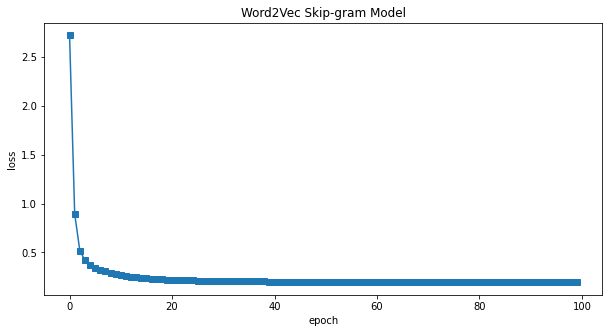

In [15]:
# visualization loss

plt.figure(figsize=(10, 5))
plt.plot(lst_loss, marker='s')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Word2Vec Skip-gram Model')
plt.show()

In [16]:
#計算字詞相似度

def get_similarity(word, top_k, model, word2idx, idx2word):
    W = (model.in_embedding.weight.data + model.out_embedding.weight.data) / 2
    idx = word2idx.get(word, None)
    
    if not idx:
        # 當出現不在字典中的字詞時，顯示Out of vocabulary error
        raise ValueError("Out of vocabulary")
    else:
        x = W[idx]
        
        # 使用cosine相似計算字詞間的相似程度
        cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
        _, topk = torch.topk(cos, top_k+1)
        
        for i in topk[1:]:
            print(f"cosine sim={cos[int(i)]:.3f}: {idx2word[int(i)]}.")

get_similarity('love', 4, model, word2idx, idx2word)

cosine sim=0.396: grower.
cosine sim=0.386: going.
cosine sim=0.377: dream.
cosine sim=0.355: catastrophic.
